In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_training_log = pd.read_csv("./VGG16_STANFORD_training.log")
df_training_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.093750,5.099177,0.177083,5.132256
1,1,0.216518,3.347981,0.364583,2.774484
2,2,0.280134,2.792656,0.354167,2.616006
3,3,0.328125,2.656115,0.437500,2.202870
4,4,0.343750,2.480187,0.447917,2.224856


In [3]:
df_train = df_training_log[["epoch","accuracy", "loss"]]
df_train["type"] = "train"
df_val = df_training_log[["epoch", "val_accuracy", "val_loss"]]
df_val =df_val.rename(columns={"val_accuracy":"accuracy", "val_loss":"loss"})
df_val["type"] = "val"
df = pd.concat([df_train, df_val])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


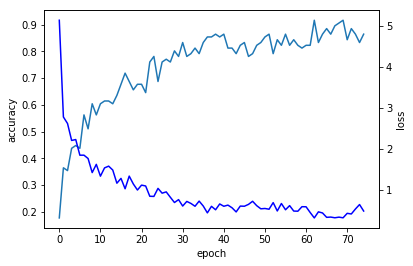

In [4]:
val_features = ["val_accuracy", "val_loss"]
ax = sns.lineplot(x="epoch", y="accuracy", data=df[df["type"] == "val"])
ax2 = plt.twinx()
sns.lineplot(x="epoch", y="loss", data=df[df["type"] == "val"], color="b", ax=ax2)
plt.show()

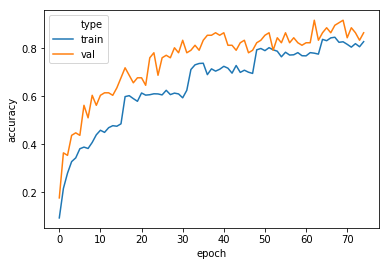

In [5]:
acc_features = ["val_accuracy", "accuracy"]
sns.lineplot(x="epoch", y="accuracy", data=df, hue="type")
plt.show()

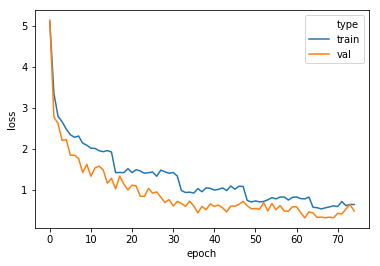

In [6]:
sns.lineplot(x="epoch", y="loss", data=df, hue="type")
plt.show()

In [8]:
df[df["type"] == "val"].sort_values(["loss","accuracy"]).head()

,epoch,accuracy,loss,type
62,62,0.916667,0.314866,val
69,69,0.916667,0.317550,val
67,67,0.895833,0.318494,val
65,65,0.885417,0.329123,val
68,68,0.906250,0.333855,val


In [9]:
df[df["type"] == "val"].sort_values(["accuracy","loss"], ascending=False).head()

,epoch,accuracy,loss,type
69,69,0.916667,0.317550,val
62,62,0.916667,0.314866,val
68,68,0.906250,0.333855,val
67,67,0.895833,0.318494,val
71,71,0.885417,0.410944,val


In [21]:
import os
CHECKPOINT_DIR = "./checkpoints"
checkpoint_files = sorted([filename for filename in os.listdir(CHECKPOINT_DIR) if "KAGGLE_ONLY" not in filename ])

In [30]:
checkpoint_files[79]

'model-VGG16_optimizer-adam_dataset-STANFORD_063_0.92_0.31.hdf5'

In [31]:
import os
import tensorflow as tf
from  tensorflow.keras import models

In [32]:
model_filepath = os.path.join(
    "models", "model-VGG16.json"
)

In [33]:
# Reload the model from the json file
with tf.device('/cpu:0'):
    with open(model_filepath) as json_file:
        json_config = json_file.read()
    model = models.model_from_json(json_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 27,623,864
Trainable params: 12,908,152
Non-trainable params: 14,715,712
___________________________________

In [35]:
high_accuracy_weight_path = os.path.join(CHECKPOINT_DIR, checkpoint_files[79])
model.load_weights(high_accuracy_weight_path)

In [36]:
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2


In [37]:
DATA_DIR = "data"
TEST_DIR = "test"
VAL_DIR = "val"
TESTFILE_PATH = os.path.join(DATA_DIR,TEST_DIR)
VALFILE_PATH = os.path.join(DATA_DIR,VAL_DIR)

testfile_list = [os.path.join(TESTFILE_PATH, filename) for filename in os.listdir(TESTFILE_PATH)]
valfile_list = []

In [38]:
for root, dirs, files in os.walk(VALFILE_PATH, topdown=False):
    for name in files:
        valfile_list.append(os.path.join(root, name))
val_class_list = [path.split("/")[2] for path in valfile_list]

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_generator(dataset_path, 
                    target_size = (224,224), batch_size=512):
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(
            dataset_path,
            target_size=target_size, class_mode='sparse', batch_size=32, shuffle=True)
    return generator 

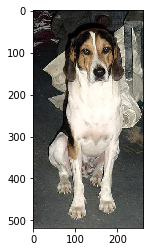

In [40]:
img=mpimg.imread(testfile_list[12])
imgplot = plt.imshow(img)
plt.show()

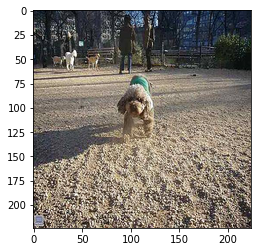

In [41]:
from PIL import Image

basewidth = 224
img = Image.open(testfile_list[0])
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((224,224), Image.ANTIALIAS)
imgplot = plt.imshow(np.array(img))
plt.show()

In [42]:
def img_to_nparray(filename):
    base = 224
    img = Image.open(filename)
    img = img.resize((base,base), Image.ANTIALIAS)
    return np.array(img)

In [43]:
test_image_array = np.array([img_to_nparray(filepath) for filepath in testfile_list])
val_image_array = np.array([img_to_nparray(filepath) for filepath in valfile_list])
val_generator = make_generator(dataset_path=VALFILE_PATH)
val_class_list = [path.split("/")[2] for path in valfile_list]

Found 2045 images belonging to 120 classes.


In [44]:
val_generator.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [45]:
test_image_array[0].shape

(224, 224, 3)

In [52]:
with tf.device('/cpu:0'):
    result = model.predict_generator(generator=val_generator)

In [58]:
result.shape

(5,)

In [54]:
shuffled_image_ids = np.arange((len(val_class_list)))
np.random.shuffle(shuffled_image_ids)
val_image_array = val_image_array[shuffled_image_ids]
val_class_list = np.array(val_class_list)[shuffled_image_ids]

In [55]:
with tf.device('/cpu:0'):
    result = model.predict_classes(val_image_array[:5])
result

array([52, 69, 88, 59, 11])

In [56]:
[val_generator.class_indices[class_name] for class_name in val_class_list[:5]]

[52, 69, 88, 59, 11]

In [78]:
test_df = pd.DataFrame([filename.split("/")[-1] for filename in testfile_list], columns = ["filename"])

In [ ]:
datagen = ImageDataGenerator()
test_generator = datagen.flow_from_dataframe(
            test_df, TESTFILE_PATH, target_size=(224,224), class_mode=None, shuffle=False)

with tf.device('/cpu:0'):
    result = model.predict_generator(generator=test_generator)
# with tf.device('/cpu:0'):
#     result = model.predict_proba(test_image_array)
result.shape

Found 10357 validated image filenames.


In [ ]:
result.shape

In [ ]:
filenames=test_generator.filenames
filenames

In [ ]:
testfile_list

In [ ]:
!kaggle competitions submit -c dog-breed-identification -f submission.csv -m "Message"